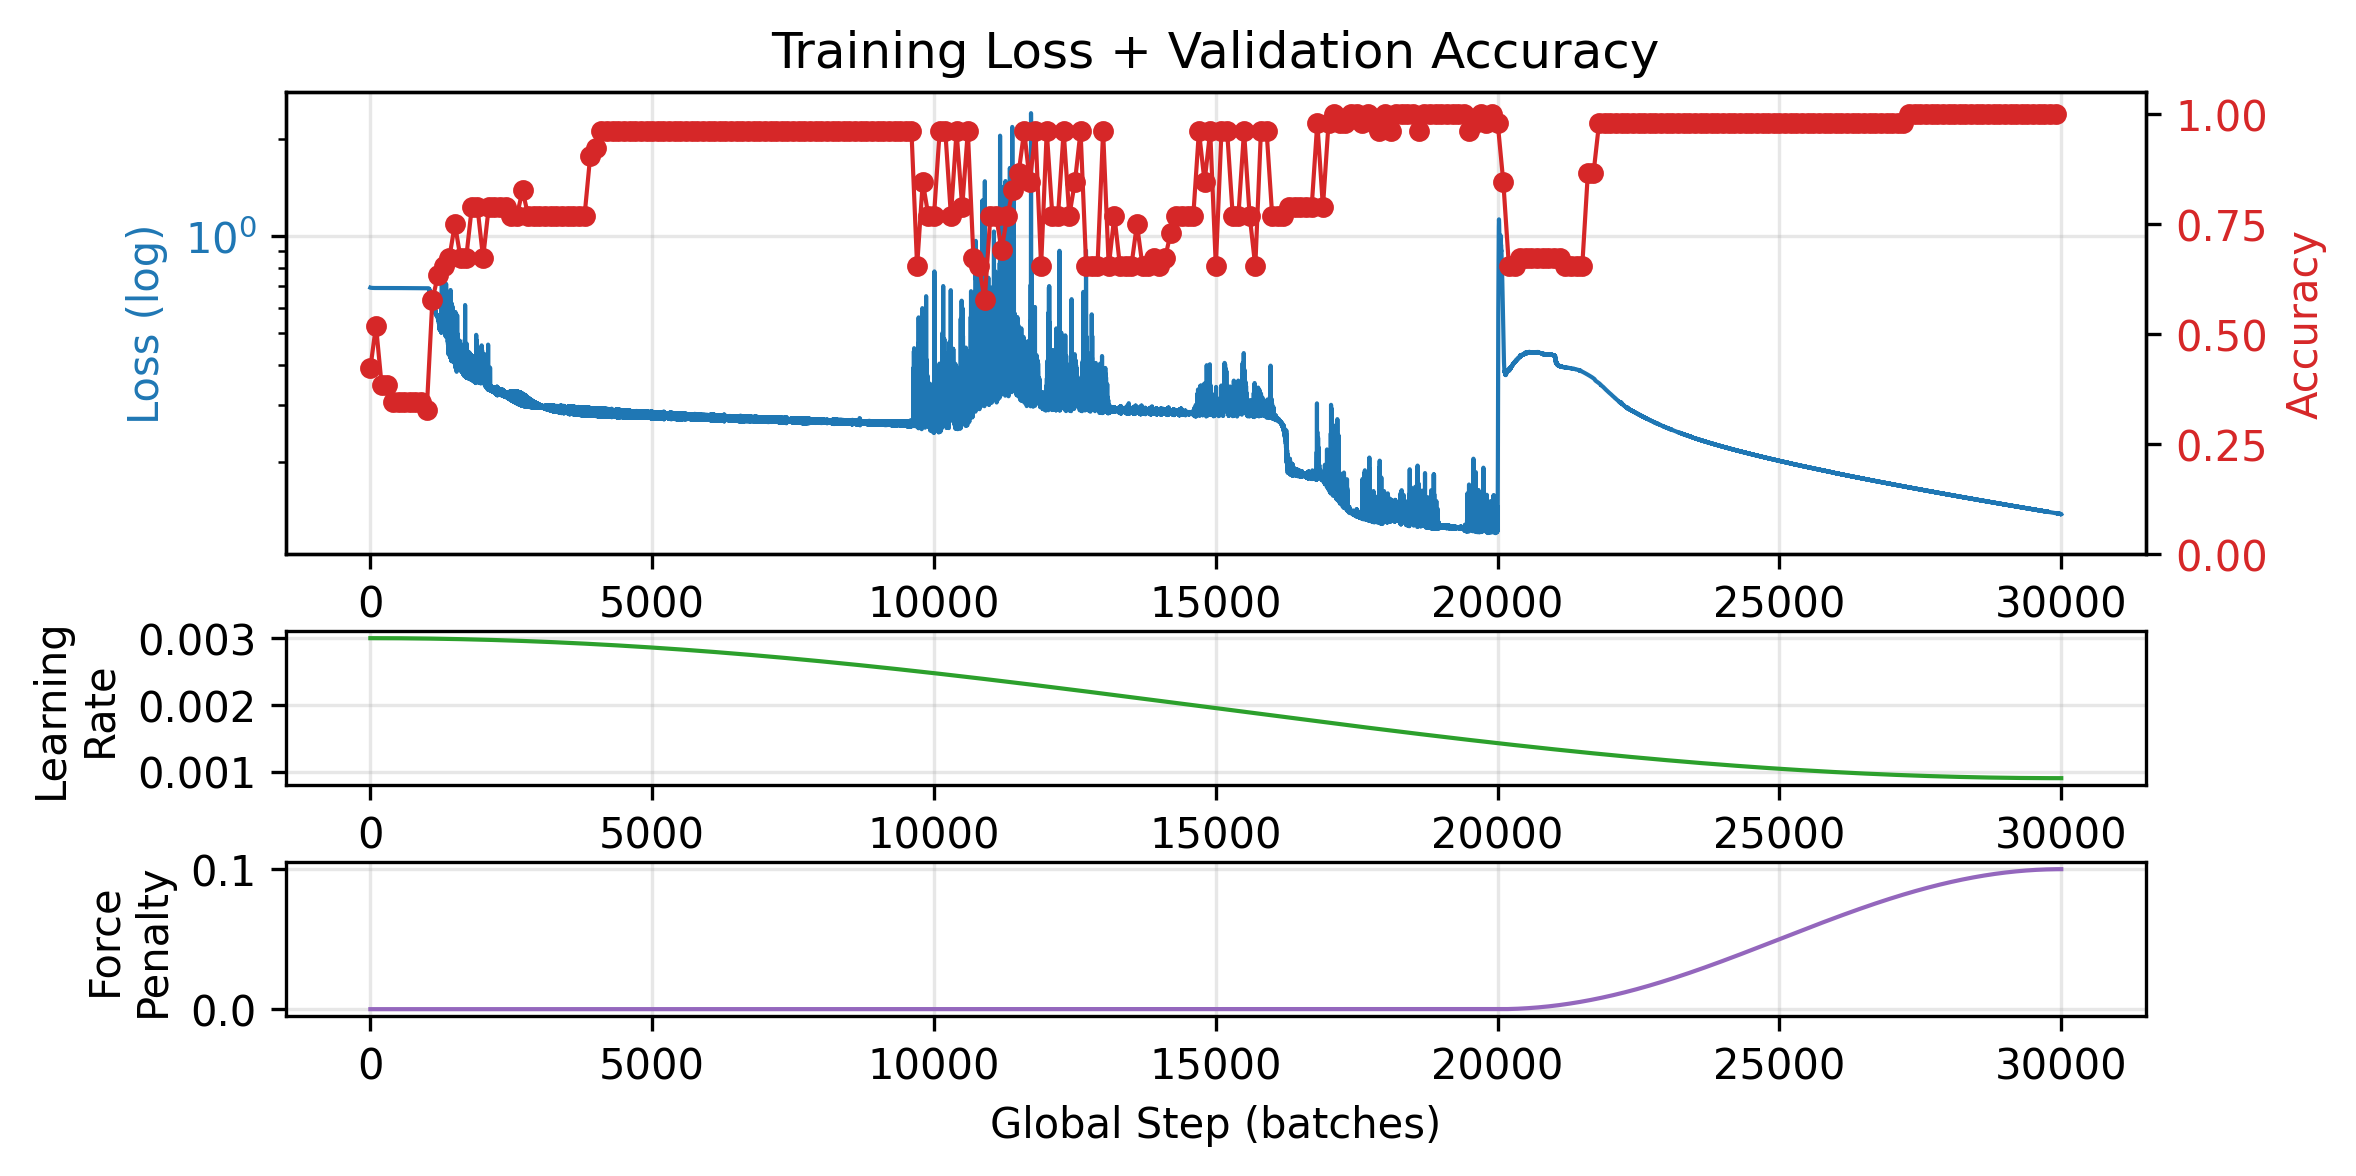

In [10]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math


# ------------------------------------------------------------
# Load logged training data
# ------------------------------------------------------------
with open("losses.pkl", "rb") as f:
    losses_steps, losses_all = pickle.load(f)

with open("accs.pkl", "rb") as f:
    accs_steps, accs_all = pickle.load(f)

losses_steps = np.array(losses_steps)
losses_all   = np.array(losses_all)
accs_steps   = np.array(accs_steps)
accs_all     = np.array(accs_all)


# ------------------------------------------------------------
# Reconstruct LR and force penalty (must match training code)
# ------------------------------------------------------------
train_epochs = 30_000
peak_lr = 3e-3
end_lr_factor = 0.3
warm = 0
total_steps = losses_steps[-1] + 1

def lr_value(global_step):
    if global_step < warm:
        return peak_lr * global_step / warm
    t = (global_step - warm) / max(1, total_steps - warm)
    cosine = 0.5 * (1 + math.cos(math.pi * t))
    return peak_lr * (end_lr_factor + (1 - end_lr_factor) * cosine)

def force_penalty_weight(epoch: int) -> float:
    start = 20_000
    duration = 10_000
    end = start + duration
    if epoch < start:
        return 0.0
    if epoch >= end:
        return 1.0
    t = (epoch - start) / duration
    return 0.05 * (1.0 - math.cos(math.pi * t))

lr_values = np.array([lr_value(s) for s in losses_steps])
force_vals_epoch = np.array([force_penalty_weight(e) for e in range(train_epochs)])
epoch_axis = np.linspace(0, losses_steps[-1], train_epochs)


# ------------------------------------------------------------
# Figure layout: top row tall, bottom rows thin
# ------------------------------------------------------------
fig = plt.figure(figsize=(8, 4), dpi=300)

# height_ratios: top = 3x taller than each lower subplot
gs = fig.add_gridspec(3, 1, height_ratios=[3, 1, 1], hspace=0.3)

# === Row 1 (tall): Loss + Accuracy ===
ax1 = fig.add_subplot(gs[0])
ax1.plot(losses_steps, losses_all, color="tab:blue", linewidth=1.0)
ax1.set_ylabel("Loss (log)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True, alpha=0.3)
ax1.semilogy()

ax2 = ax1.twinx()
ax2.plot(accs_steps, accs_all, color="tab:red", marker="o", linestyle="-",
         linewidth=1.0, markersize=4)
ax2.set_ylabel("Accuracy", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.set_ylim(0.0, 1.05)
ax1.set_title("Training Loss + Validation Accuracy")


# === Row 2 (short): Learning Rate ===
ax3 = fig.add_subplot(gs[1])
ax3.plot(losses_steps, lr_values, color="tab:green", linewidth=1.0)
ax3.set_ylabel("Learning\nRate")
ax3.grid(True, alpha=0.3)


# === Row 3 (short): Force Penalty ===
ax4 = fig.add_subplot(gs[2])
ax4.plot(epoch_axis, force_vals_epoch, color="tab:purple", linewidth=1.0)
ax4.set_ylabel("Force\nPenalty")
ax4.set_xlabel("Global Step (batches)")
ax4.grid(True, alpha=0.3)


plt.show()
